<a href="https://colab.research.google.com/github/Vinsocf/CapstoneProject/blob/main/BCW_Model_Building_Evaluation_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
pip install catboost

In [101]:
import platform

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
#from imblearn.over_sampling import SMOTE
#from tabulate import tabulate
import itertools
import seaborn as sns
from copy import copy
from sklearn.externals import joblib
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer, RobustScaler
import sklearn
from sklearn.externals import joblib
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Normalizer, FunctionTransformer
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import train_test_split
#import sklearn.model_selection.StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score, log_loss, r2_score
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [102]:
# notice: installing imblearn might takes a few minutes
#!conda install -c anaconda imblearn -y

In [103]:
# notice: installing tabulate might takes a few minutes
#!conda install -c anaconda tabulate -y

### 1. The LoadData routiine is used to read dataset, and create training and testing datasets

In [104]:
def LoadData():
    global feature_names, response_name, n_features, model_full  
    model_full = pd.read_csv('https://raw.githubusercontent.com/Vinsocf/emotions/main/Wisconsin-bc-data.csv')
        
    # we change the class values (at the column number 2) from B to 0 and from M to 1
    model_full.iloc[:,1].replace('B', 0,inplace=True)
    model_full.iloc[:,1].replace('M', 1,inplace=True)
    response_name = ['diagnosis']
    drop_list = ['Unnamed: 32','id','diagnosis']
    model_full_x= model_full.drop(drop_list,axis = 1)
    X = model_full_x
    y = model_full.diagnosis
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size = 0.3,
                                                        random_state = 12345)
    return X_train, y_train, X_test, y_test

### Features selected from Part 2 

In [105]:
# 1. Feature selection with correlation (16)
fs_corr = ['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean','symmetry_mean',
                     'fractal_dimension_mean', 'texture_se', 'area_se','smoothness_se', 'concavity_se',
                     'symmetry_se', 'fractal_dimension_se','smoothness_worst', 'concavity_worst', 
                     'symmetry_worst', 'fractal_dimension_worst']
    
    # 2. Univariate feature selection SelectKBest, chi2
fs_chi2 = ['texture_mean', 'area_mean', 'concavity_mean', 'symmetry_mean', 'area_se', 
                     'concavity_se', 'smoothness_worst', 'concavity_worst', 'symmetry_worst', 
                     'fractal_dimension_worst']
    
    # 3. Recursive feature elimination (RFE) with random forest
fs_rfe = ['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean', 'area_se', 
              'smoothness_se', 'concavity_se', 'smoothness_worst', 'concavity_worst', 'symmetry_worst']
    
    # 4. Recursive feature elimination with cross validation(RFECV) with random forest
fs_rfecv = ['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean','fractal_dimension_mean'
                , 'area_se', 'concavity_se', 'concavity_worst', 'symmetry_worst']
    
    # 5. Tree based feature selection with random forest classification
fs_rf = ['texture_mean', 'area_mean', 'concavity_mean', 'area_se', 'concavity_se', 
             'fractal_dimension_se', 'smoothness_worst','concavity_worst', 'symmetry_worst', 
             'fractal_dimension_worst']
    
    # 6. ExtraTree based feature selection 
fs_extraTree = ['texture_mean', 'area_mean', 'concavity_mean', 'fractal_dimension_mean', 'area_se', 
                    'concavity_se','smoothness_worst', 'concavity_worst', 
                    'symmetry_worst','fractal_dimension_worst']
    
    # 7. L1 feature selection (LinearSVC)
fs_l1 = ['texture_mean', 'area_mean', 'area_se']
    
    # 8. Vote based feature selection
fs_voted = ['texture_mean',  'area_mean',  'smoothness_mean',  'concavity_mean',  
                     'fractal_dimension_mean',  'area_se',  'concavity_se',  'smoothness_worst',  
                     'concavity_worst',  'symmetry_worst',  'fractal_dimension_worst']
    

In [106]:
x_train, y_train, x_test, y_test = LoadData()

# Uncomment for feature selection method

In [107]:
# Correlation
X_train = x_train[fs_corr]
X_test = x_test[fs_corr]

# Chi2
#X_train = x_train[fs_chi2]
#X_test = x_test[fs_chi2]

# RFE
#X_train = x_train[fs_rfe]
#X_test = x_test[fs_rfe]

# RFECV
#X_train = x_train[fs_rfecv]
#X_test = x_test[fs_rfecv]

# RF
#X_train = x_train[fs_rf]
#X_test = x_test[fs_rf]

# Extra Trees
#X_train = x_train[fs_extraTree]
#X_test = x_test[fs_extraTree]

# l1
#X_train = x_train[fs_l1]
#X_test = x_test[fs_l1]

# Voted
#X_train = x_train[fs_voted]
#X_test = x_test[fs_voted]

# scaling data
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.fit_transform(X_test)

In [108]:
print('Size of data:')
print ('The train data has {0} rows and {1} columns'.format(X_train.shape[0],X_train.shape[1]))
print ('----------------------------')
print ('The test data has {0} rows and {1} columns'.format(X_test.shape[0],X_test.shape[1]))

Size of data:
The train data has 398 rows and 16 columns
----------------------------
The test data has 171 rows and 16 columns


###  Plot the ROC_Curve and Precision-Recall curve. 

In [109]:
def Plot_ROC_Precision_Recall(label):
    class_names = [0, 1]
    fig, (left, right) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive_rate, true_positive_rate, color='darkorange', label=label)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (area = %0.7f)' % auc)
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    precision, recall, _ = precision_recall_curve(y_test, y_probabilities_success)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

    plt.tight_layout()
    plt.show()

### This routine is used to plot the predictor (a.k.a feature) importances. 

In [110]:
def Plot_Predictor_Importance(logisticRegression = True):
    if(logisticRegression):
        feature_importance = best_model.feature_importances_
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)
        y_pos = np.arange(sorted_idx.shape[0]) + .5
        fig, ax = plt.subplots()
        fig.set_size_inches(8, 5)
        ax.barh(y_pos, feature_importance[sorted_idx], align='center', color='green', ecolor='black', height=0.5)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(feature_names)
        ax.invert_yaxis()
        ax.set_xlabel('Relative Importance')
        ax.set_title('Predictor Importance')
        plt.show()

### This routine is used to summarize the metrics for the model.

In [111]:
def Print_Model_Metrics(algoName):
    global testPerformanceData
    true_negative  = cm[0, 0]
    true_positive  = cm[1, 1]
    false_negative = cm[1, 0]
    false_positive = cm[0, 1]
    total = true_negative + true_positive + false_negative + false_positive

    accuracy_ = (true_positive + true_negative)/total
    precision_ = (true_positive)/(true_positive + false_positive)
    recall_ = (true_positive)/(true_positive + false_negative)
    misclassification_rate = (false_positive + false_negative)/total
    F1_ = (2*true_positive)/(2*true_positive + false_positive + false_negative)
    assert accuracy == accuracy_, "accuracy score does not agree"
    assert precision == precision_, "precision score does not agree"
    assert recall == recall_, "recall score does not agree"
    assert round(F1,6) == round(F1_,6), "F1: " + str(F1) + " != F1_: " + str(F1_)

    header = ["Metric", "Testing Performance"]
    table = [["accuracy",               accuracy],
             ["precision",              precision],
             ["recall",                 recall],
             ["misclassification rate", misclassification_rate],
             ["F1",                     F1],
             ["r2",                     r2],
             ["AUC",                    auc],
             ["mse",                    mse],
             ["logloss",                logloss]
            ]

    print(tabulate(table, header, tablefmt="fancy_grid"))
    testPerformanceData = testPerformanceData.append({'Algorithm' : algoName,'Accuracy' : accuracy,'AUC' : auc,'Precision' : precision,'Recall' : recall,'F1' : F1},ignore_index = True)

### This routine plots the confusion matrix. 

In [112]:
def Plot_Confusion_Matrix(best_model):
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    title='Confusion matrix (on test data)'
    classes = [0, 1]
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    c_report = classification_report(y_test, y_predicted_test)
    print('\nClassification report:\n', c_report)

    ntotal = len(y_test)
    correct = y_test == y_predicted_test
    numCorrect = sum(correct)
    percent = round( (100.0*numCorrect)/ntotal, 6)
    print("\nCorrect classifications on test data: {0:d}/{1:d} {2:8.3f}%".format(numCorrect,
                                                                                 ntotal,
                                                                                 percent))
    prediction_score = 100.0*best_model.score(X_test, y_test)
    assert (round(percent,3) == round(prediction_score, 3)), "prediction score does not agree"

In [113]:
def dataPreProc(fs):
    X_train, y_train, X_test, y_test = LoadData(fs)
    seed = 7
    np.random.seed(seed)
    # scaling data
    scale = StandardScaler()
    X_tr = scale.fit_transform(X_train)
    X_te = scale.fit_transform(X_test)
    return X_tr, X_te

In [114]:
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [115]:
def best_mdl():
    print('\n Best estimator:')
    print(model.best_estimator_)
    print('\n Best score:')
    print(model.best_score_ * 2 - 1)
    print('\n Best parameters:')
    print(model.best_params_)
    results = pd.DataFrame(model.cv_results_)
    print('\n CV results:')
    print(results.head())
    #best_model = results.best_estimator_
    best_model = model_result.best_estimator_
    return best_model

### Exploratory Data Analysis

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
#X_train, y_train, X_test, y_test = LoadData()
model_full.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [118]:
model_full.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [119]:
model_full.dtypes

id                           int64
diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

Distribution of Cancer patients on whole data


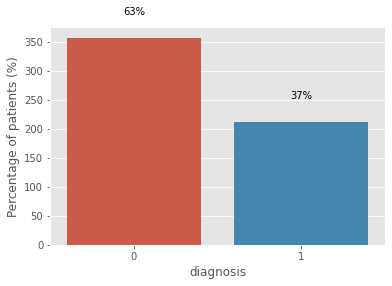

In [120]:
# lets get the % of Cancer Patients
print('Distribution of Cancer patients on whole data')
ax = sns.countplot(model_full['diagnosis'])
ax.set_ylabel('Percentage of patients (%)')
bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]
for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r
    ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
    ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")

Distribution of the data:
----------------------------------------------------
The total data has 569 rows and 33 columns

Malignent cases = 212  and % = 37.26 

Benign cases = 357  and % = 62.74 

----------------------------------------------------
Distribution of training data
----------------------------------------------------
The train data has 398 rows and 16 columns

The training data % = 69.95 

Malignent cases = 152  and % = 38.19 

Benign cases = 246  and % = 61.81 

----------------------------------------------------
Distribution of testing data
----------------------------------------------------
The test data has 171 rows and 16 columns

The testing data % = 30.05 

Malignent cases = 60  and % = 35.09 

Benign cases = 111  and % = 64.91 

Training data : Distribution of patients


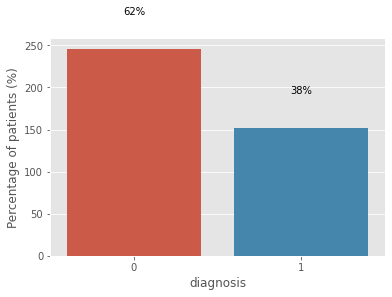

In [121]:
no, yes = model_full['diagnosis'].value_counts()
#X_train, y_train, X_test, y_test = LoadData()
print('Distribution of the data:')
print ('----------------------------------------------------')
print ('The total data has {0} rows and {1} columns'.format(model_full.shape[0],model_full.shape[1]))
print ('')
print ('Malignent cases = {0}  and % = {1} '.format(yes,np.round((yes/model_full.shape[0])*100,2)))
print ('')
print ('Benign cases = {0}  and % = {1} '.format(no,np.round((no/model_full.shape[0])*100,2)))
print ('')
print ('----------------------------------------------------')
print ('Distribution of training data')
print ('----------------------------------------------------')
print ('The train data has {0} rows and {1} columns'.format(X_train.shape[0],X_train.shape[1]))
print ('')
print ('The training data % = {0} '.format(np.round((X_train.shape[0]/model_full.shape[0])*100,2)))
print ('')
y_tr = y_train.sum()
n_tr = X_train.shape[0] -y_tr    #yes1
print ('Malignent cases = {0}  and % = {1} '.format(y_tr,np.round((y_tr/X_train.shape[0])*100,2)))
print ('')
print ('Benign cases = {0}  and % = {1} '.format(n_tr,np.round((n_tr/X_train.shape[0])*100,2)))
print ('')
print ('----------------------------------------------------')
print ('Distribution of testing data')
print ('----------------------------------------------------')
print ('The test data has {0} rows and {1} columns'.format(X_test.shape[0],X_test.shape[1]))
print ('')
print ('The testing data % = {0} '.format(np.round((X_test.shape[0]/model_full.shape[0])*100,2)))
print ('')
y_te = y_test.sum()
n_te = X_test.shape[0] -y_te
print ('Malignent cases = {0}  and % = {1} '.format(y_te,np.round((y_te/X_test.shape[0])*100,2)))
print ('')
print ('Benign cases = {0}  and % = {1} '.format(n_te,np.round((n_te/X_test.shape[0])*100,2)))
print ('')
# lets get the % of Blood Transfusion patients
print('Training data : Distribution of patients')
ax = sns.countplot(y_train)
ax.set_ylabel('Percentage of patients (%)')
bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]
for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r
    ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
    ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")

Testing data : Distribution of patients


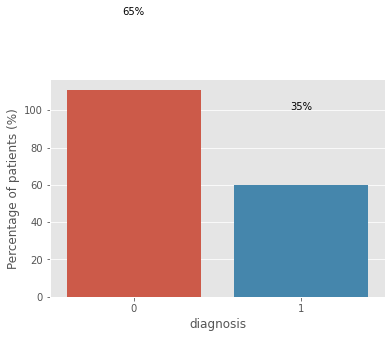

In [122]:
# lets get the % of Blood Transfusion patients
print('Testing data : Distribution of patients')
ax = sns.countplot(y_test)
ax.set_ylabel('Percentage of patients (%)')
bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]
for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r
    ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
    ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")

### Build models 

### Define basic non-linear classifiers

In [123]:
nonlr_clf_dict = dict()

# 1
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
nonlr_clf_dict['Logistic Regression'] = clf

# 2
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
nonlr_clf_dict['Random Forest Classifier'] = clf

# 3
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
nonlr_clf_dict['Gradient Boosting Classifier'] = clf

# 4
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier()
nonlr_clf_dict['Extra Trees Classifier'] = clf

# 5
from xgboost import XGBClassifier
clf = XGBClassifier()
nonlr_clf_dict['XGB Classifier'] = clf

# 6
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
nonlr_clf_dict['KNeighbors Classifier'] = clf

# 7
from sklearn.svm import SVC
clf = SVC(kernel='rbf',probability=True)   
nonlr_clf_dict['SVM Classifier'] = clf

# 8
from sklearn.naive_bayes import GaussianNB  
clf = GaussianNB() 
nonlr_clf_dict['naive_bayes'] = clf

# 9
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='gini')
nonlr_clf_dict['Decision Tree Classifier'] = clf

# 10
from xgboost import XGBClassifier
clf = XGBClassifier()
nonlr_clf_dict['XGBoost Classifierr'] = clf

# 11
#from sklearn.linear_model import SGDClassifier
#clf = SGDClassifier()
#nonlr_clf_dict['Stochastic Gradient Decent Classifier'] = clf

# 12
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
nonlr_clf_dict['AdaBoost Classifier'] = clf
# 13
from catboost import CatBoostClassifier
clf = CatBoostClassifier()
nonlr_clf_dict['catboost Classifier'] = clf

### Build models 

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
Logistic Regression
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f accuracy 0.9723734177215189 0.012222566146985407

---------------------------------------------------------------------
Logistic Regression
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f precision 0.9804166666666667 0.01600781059358212

---------------------------------------------------------------------
Logistic Regression
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f recall 0.9475268817204302 0.04370091435653468

---------------------------------------------------------------------
Logistic Regression
-------------------------------------

[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished


---------------------------------------------------------------------
Logistic Regression
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f average_precision 0.994017665645935 0.005364974553079667

---------------------------------------------------------------------
Logistic Regression
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f roc_auc 0.994294930875576 0.006767943324947326

Average precision-recall score: 0.99
╒════════════════════════╤═══════════════════════╕
│ Metric                 │   Testing Performance │
╞════════════════════════╪═══════════════════════╡
│ accuracy               │             0.959064  │
├────────────────────────┼───────────────────────┤
│ precision              │             0.964912  │
├────────────────────────┼───────────────────────┤
│ recall        

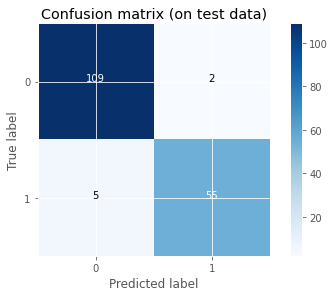

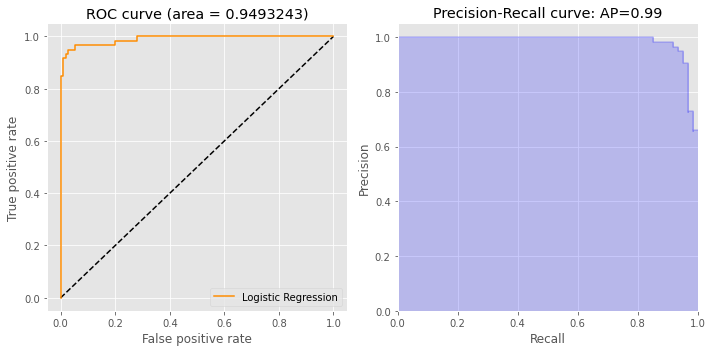

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
Random Forest Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f accuracy 0.952373417721519 0.038978556054299805



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
Random Forest Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f precision 0.9397619047619047 0.06164597924738982



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
Random Forest Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f recall 0.9408602150537634 0.012939018457196846



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
Random Forest Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f f1 0.9346815087524313 0.0348273224683974



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
Random Forest Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f average_precision 0.988158242066476 0.010958388145986504



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.8s finished


---------------------------------------------------------------------
Random Forest Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f roc_auc 0.9916222075927145 0.007922327291841181

Average precision-recall score: 0.98
╒════════════════════════╤═══════════════════════╕
│ Metric                 │   Testing Performance │
╞════════════════════════╪═══════════════════════╡
│ accuracy               │             0.953216  │
├────────────────────────┼───────────────────────┤
│ precision              │             0.948276  │
├────────────────────────┼───────────────────────┤
│ recall                 │             0.916667  │
├────────────────────────┼───────────────────────┤
│ misclassification rate │             0.0467836 │
├────────────────────────┼───────────────────────┤
│ F1                     │             0.932203  │
├────────────────────────┼───────────────────────┤
│ r2

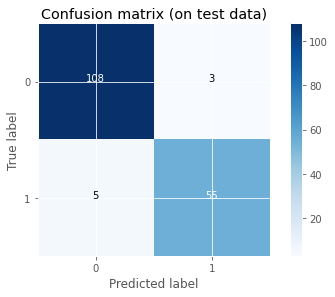

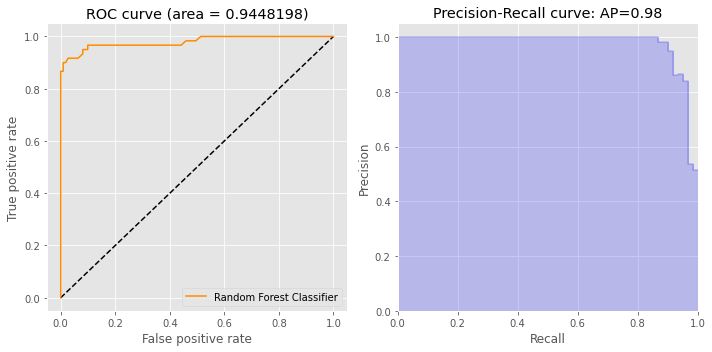

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
Gradient Boosting Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f accuracy 0.9547784810126583 0.024493221138709397



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
Gradient Boosting Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f precision 0.9376389265383572 0.04854266613219397



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
Gradient Boosting Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f recall 0.9473118279569892 0.02662674778370967



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
Gradient Boosting Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f f1 0.9417176153411313 0.029919385543328667



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
Gradient Boosting Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f average_precision 0.9864414390971223 0.01391099866765725



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.8s finished


---------------------------------------------------------------------
Gradient Boosting Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f roc_auc 0.9917569453587886 0.008573408438324047

Average precision-recall score: 0.97
╒════════════════════════╤═══════════════════════╕
│ Metric                 │   Testing Performance │
╞════════════════════════╪═══════════════════════╡
│ accuracy               │             0.912281  │
├────────────────────────┼───────────────────────┤
│ precision              │             0.881356  │
├────────────────────────┼───────────────────────┤
│ recall                 │             0.866667  │
├────────────────────────┼───────────────────────┤
│ misclassification rate │             0.0877193 │
├────────────────────────┼───────────────────────┤
│ F1                     │             0.87395   │
├────────────────────────┼───────────────────────┤


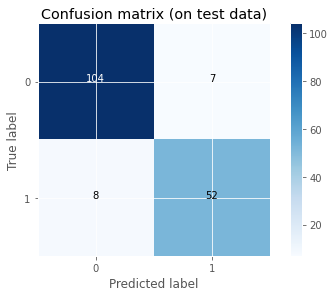

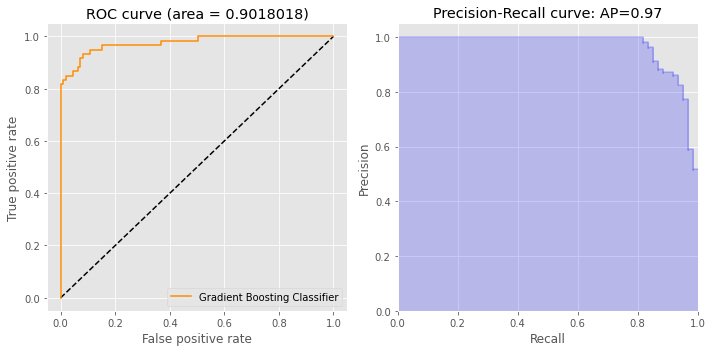

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
Extra Trees Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f accuracy 0.9599050632911392 0.02993955214372616



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
Extra Trees Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f precision 0.9442461122379987 0.0655236479276049



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
Extra Trees Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f recall 0.9344086021505376 0.040990172506454696



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
Extra Trees Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f f1 0.9503626754146163 0.03591654520358239



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
Extra Trees Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f average_precision 0.9883630515367956 0.009023716448885749



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.5s finished


---------------------------------------------------------------------
Extra Trees Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f roc_auc 0.9895285933728332 0.008458273521886243

Average precision-recall score: 0.98
╒════════════════════════╤═══════════════════════╕
│ Metric                 │   Testing Performance │
╞════════════════════════╪═══════════════════════╡
│ accuracy               │             0.959064  │
├────────────────────────┼───────────────────────┤
│ precision              │             0.949153  │
├────────────────────────┼───────────────────────┤
│ recall                 │             0.933333  │
├────────────────────────┼───────────────────────┤
│ misclassification rate │             0.0409357 │
├────────────────────────┼───────────────────────┤
│ F1                     │             0.941176  │
├────────────────────────┼───────────────────────┤
│ r2  

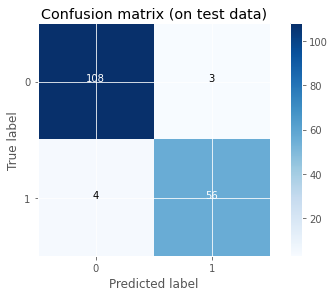

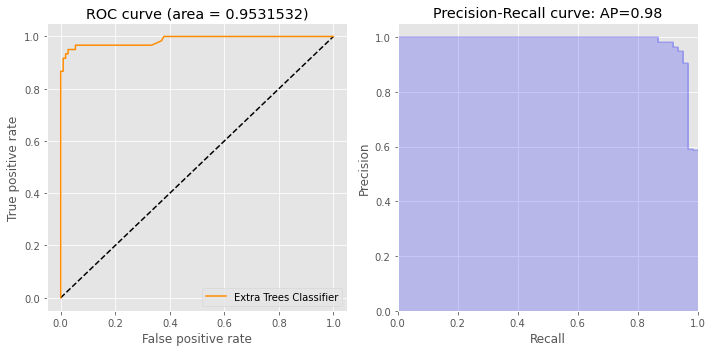

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
XGB Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f accuracy 0.9548101265822784 0.036704304605949346



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
XGB Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f precision 0.9320028790159001 0.05922423263189786



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
XGB Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f recall 0.953978494623656 0.03299095760381326



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
XGB Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f f1 0.9424660696347276 0.044818980716819744



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
XGB Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f average_precision 0.9863025553281487 0.010567948212371874



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.2s finished


---------------------------------------------------------------------
XGB Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f roc_auc 0.9898674566600836 0.00832131695181983

Average precision-recall score: 0.98
╒════════════════════════╤═══════════════════════╕
│ Metric                 │   Testing Performance │
╞════════════════════════╪═══════════════════════╡
│ accuracy               │             0.964912  │
├────────────────────────┼───────────────────────┤
│ precision              │             0.95      │
├────────────────────────┼───────────────────────┤
│ recall                 │             0.95      │
├────────────────────────┼───────────────────────┤
│ misclassification rate │             0.0350877 │
├────────────────────────┼───────────────────────┤
│ F1                     │             0.95      │
├────────────────────────┼───────────────────────┤
│ r2           

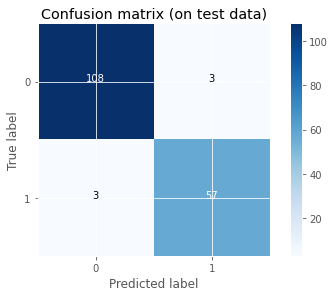

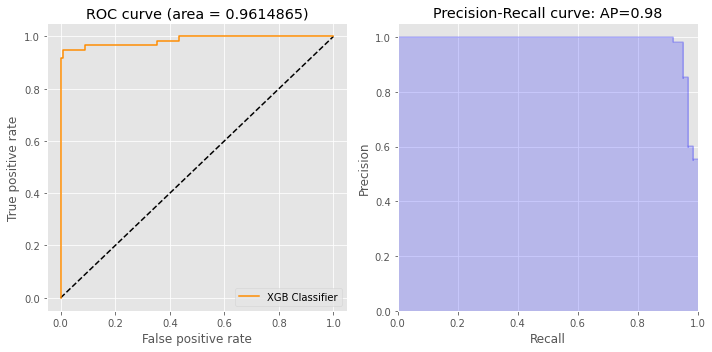


---------------------------------------------------------------------
KNeighbors Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f accuracy 0.9498101265822785 0.030567949478675804

---------------------------------------------------------------------
KNeighbors Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f precision 0.941650444938821 0.051324995490328144

---------------------------------------------------------------------
KNeighbors Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f recall 0.927741935483871 0.0377870942651717

---------------------------------------------------------------------
KNeighbors Classifier
------------------------------

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished


---------------------------------------------------------------------
KNeighbors Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f average_precision 0.9711501944648664 0.02692523267984865

---------------------------------------------------------------------
KNeighbors Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f roc_auc 0.9786375246872943 0.0196058739758022

Average precision-recall score: 0.97
╒════════════════════════╤═══════════════════════╕
│ Metric                 │   Testing Performance │
╞════════════════════════╪═══════════════════════╡
│ accuracy               │             0.947368  │
├────────────────────────┼───────────────────────┤
│ precision              │             0.963636  │
├────────────────────────┼───────────────────────┤
│ recall     

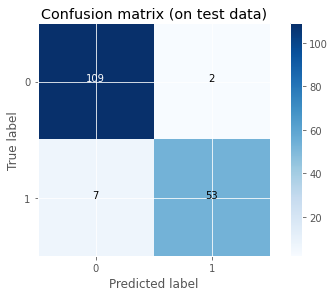

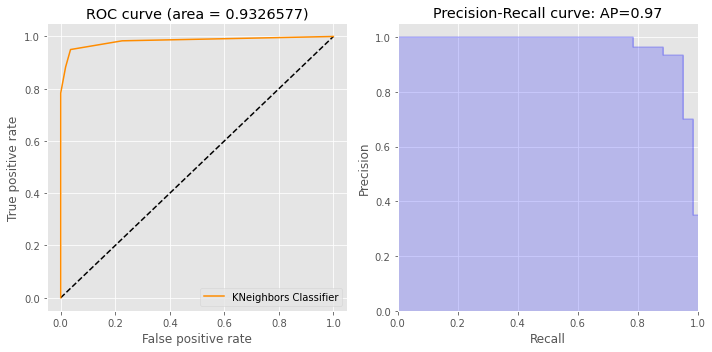


---------------------------------------------------------------------
SVM Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f accuracy 0.959873417721519 0.024160433900396072

---------------------------------------------------------------------
SVM Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f precision 0.9489784946236559 0.042244655729223986



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
SVM Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f recall 0.9475268817204302 0.025711294094329207

---------------------------------------------------------------------
SVM Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f f1 0.947926880909977 0.03015655644249013

---------------------------------------------------------------------
SVM Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f average_precision 0.9883307394102978 0.011410453169872069



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.1s finished


---------------------------------------------------------------------
SVM Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f roc_auc 0.9897637919684004 0.010723910678778604

Average precision-recall score: 0.98
╒════════════════════════╤═══════════════════════╕
│ Metric                 │   Testing Performance │
╞════════════════════════╪═══════════════════════╡
│ accuracy               │             0.953216  │
├────────────────────────┼───────────────────────┤
│ precision              │             0.964286  │
├────────────────────────┼───────────────────────┤
│ recall                 │             0.9       │
├────────────────────────┼───────────────────────┤
│ misclassification rate │             0.0467836 │
├────────────────────────┼───────────────────────┤
│ F1                     │             0.931034  │
├────────────────────────┼───────────────────────┤
│ r2          

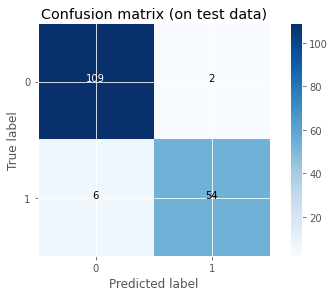

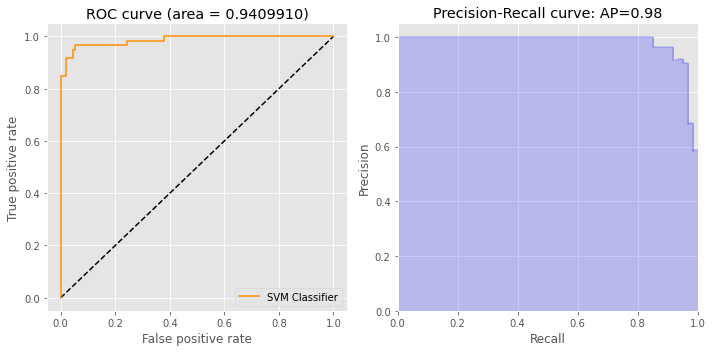


---------------------------------------------------------------------
naive_bayes
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f accuracy 0.9322784810126581 0.05273171828342878

---------------------------------------------------------------------
naive_bayes
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f precision 0.9192896033186415 0.0964774795324931

---------------------------------------------------------------------
naive_bayes
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f recall 0.9141935483870969 0.03410077357920826

---------------------------------------------------------------------
naive_bayes
---------------------------------------------------------------------


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished


Average precision-recall score: 0.88
╒════════════════════════╤═══════════════════════╕
│ Metric                 │   Testing Performance │
╞════════════════════════╪═══════════════════════╡
│ accuracy               │              0.888889 │
├────────────────────────┼───────────────────────┤
│ precision              │              0.836066 │
├────────────────────────┼───────────────────────┤
│ recall                 │              0.85     │
├────────────────────────┼───────────────────────┤
│ misclassification rate │              0.111111 │
├────────────────────────┼───────────────────────┤
│ F1                     │              0.842975 │
├────────────────────────┼───────────────────────┤
│ r2                     │              0.512162 │
├────────────────────────┼───────────────────────┤
│ AUC                    │              0.879955 │
├────────────────────────┼───────────────────────┤
│ mse                    │              0.111111 │
├────────────────────────┼───────────────────

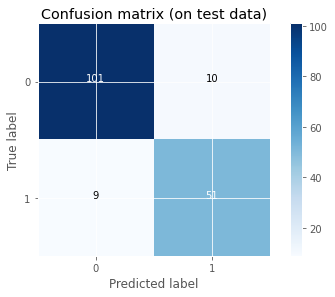

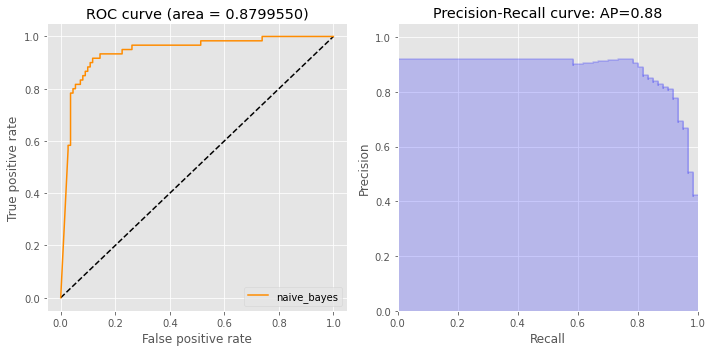


---------------------------------------------------------------------
Decision Tree Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f accuracy 0.9271518987341771 0.021458543181415532

---------------------------------------------------------------------
Decision Tree Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f precision 0.9131222943722944 0.05888234147160623

---------------------------------------------------------------------
Decision Tree Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f recall 0.9141935483870969 0.017383475593945097

---------------------------------------------------------------------
Decision Tree Classifier
---------------

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished


---------------------------------------------------------------------
Decision Tree Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f roc_auc 0.9225402677199913 0.03143463227149307

Average precision-recall score: 0.79
╒════════════════════════╤═══════════════════════╕
│ Metric                 │   Testing Performance │
╞════════════════════════╪═══════════════════════╡
│ accuracy               │             0.900585  │
├────────────────────────┼───────────────────────┤
│ precision              │             0.877193  │
├────────────────────────┼───────────────────────┤
│ recall                 │             0.833333  │
├────────────────────────┼───────────────────────┤
│ misclassification rate │             0.0994152 │
├────────────────────────┼───────────────────────┤
│ F1                     │             0.854701  │
├────────────────────────┼───────────────────────┤
│ r2 

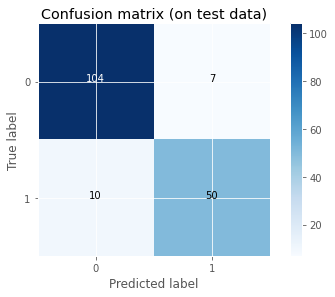

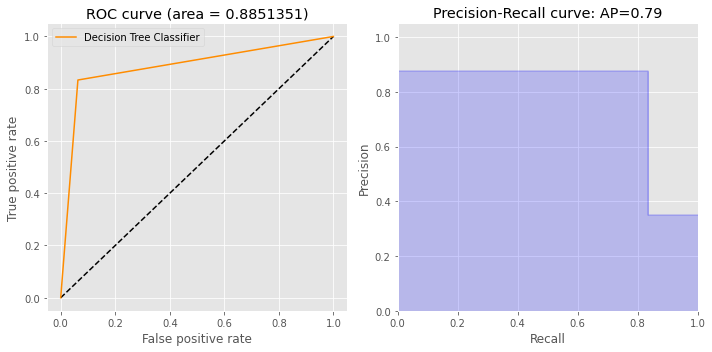

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
XGBoost Classifierr
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f accuracy 0.9548101265822784 0.036704304605949346



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
XGBoost Classifierr
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f precision 0.9320028790159001 0.05922423263189786



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
XGBoost Classifierr
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f recall 0.953978494623656 0.03299095760381326



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
XGBoost Classifierr
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f f1 0.9424660696347276 0.044818980716819744



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
XGBoost Classifierr
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f average_precision 0.9863025553281487 0.010567948212371874



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.2s finished


---------------------------------------------------------------------
XGBoost Classifierr
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f roc_auc 0.9898674566600836 0.00832131695181983

Average precision-recall score: 0.98
╒════════════════════════╤═══════════════════════╕
│ Metric                 │   Testing Performance │
╞════════════════════════╪═══════════════════════╡
│ accuracy               │             0.964912  │
├────────────────────────┼───────────────────────┤
│ precision              │             0.95      │
├────────────────────────┼───────────────────────┤
│ recall                 │             0.95      │
├────────────────────────┼───────────────────────┤
│ misclassification rate │             0.0350877 │
├────────────────────────┼───────────────────────┤
│ F1                     │             0.95      │
├────────────────────────┼───────────────────────┤
│ r2      

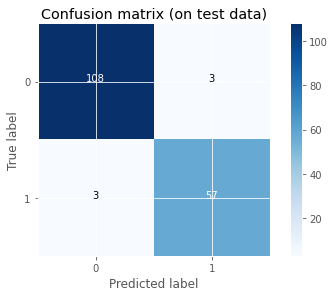

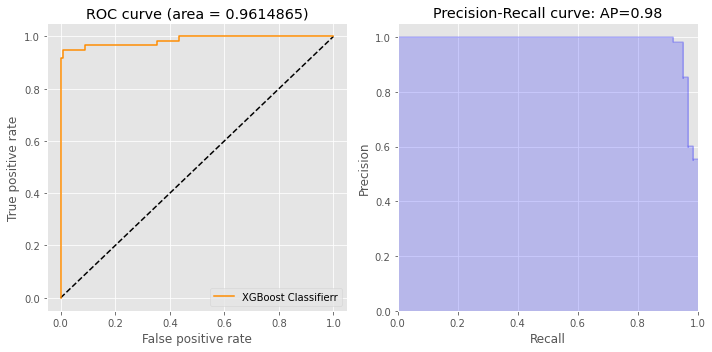

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
AdaBoost Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f accuracy 0.9422784810126583 0.028019002353219725



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
AdaBoost Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f precision 0.9452362707535121 0.04046991178027332



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
AdaBoost Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f recall 0.9012903225806452 0.04185766145411391



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
AdaBoost Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f f1 0.9224431737860908 0.03764706883396423



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
AdaBoost Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f average_precision 0.9795451562228757 0.011684984081609683



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.5s finished


---------------------------------------------------------------------
AdaBoost Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f roc_auc 0.9855074829931972 0.008574258922409629

Average precision-recall score: 0.98
╒════════════════════════╤═══════════════════════╕
│ Metric                 │   Testing Performance │
╞════════════════════════╪═══════════════════════╡
│ accuracy               │             0.953216  │
├────────────────────────┼───────────────────────┤
│ precision              │             0.948276  │
├────────────────────────┼───────────────────────┤
│ recall                 │             0.916667  │
├────────────────────────┼───────────────────────┤
│ misclassification rate │             0.0467836 │
├────────────────────────┼───────────────────────┤
│ F1                     │             0.932203  │
├────────────────────────┼───────────────────────┤
│ r2     

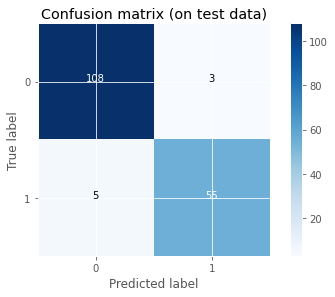

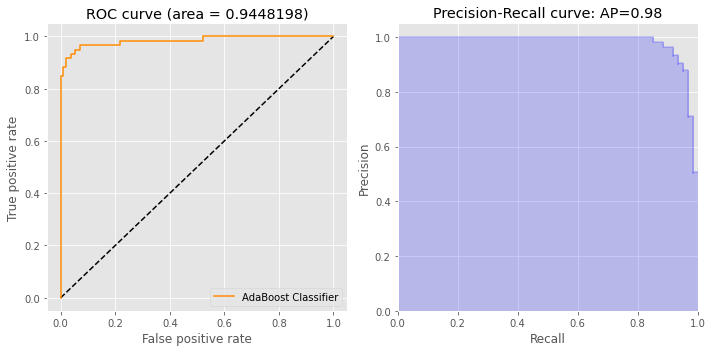

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   29.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
catboost Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f accuracy 0.9523417721518987 0.03295417739898211



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   27.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
catboost Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f precision 0.9327649769585253 0.06077228143233021



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   28.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
catboost Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f recall 0.9473118279569892 0.03396215749892418



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   27.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
catboost Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f f1 0.9390136526371687 0.04026924886728545



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   28.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


---------------------------------------------------------------------
catboost Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f average_precision 0.9887513961689424 0.009115984990437193



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   27.1s finished


---------------------------------------------------------------------
catboost Classifier
---------------------------------------------------------------------
Cross Validation scores on training data
Scoring Name: CV mean: %.5f CV std: %.5f roc_auc 0.9920075488259819 0.006777475813221669

Learning rate set to 0.006952
0:	learn: 0.6818670	total: 51.5ms	remaining: 51.5s
1:	learn: 0.6718584	total: 55.9ms	remaining: 27.9s
2:	learn: 0.6632133	total: 60.3ms	remaining: 20s
3:	learn: 0.6513062	total: 64.6ms	remaining: 16.1s
4:	learn: 0.6421039	total: 69.1ms	remaining: 13.8s
5:	learn: 0.6303812	total: 73.5ms	remaining: 12.2s
6:	learn: 0.6201155	total: 78ms	remaining: 11.1s
7:	learn: 0.6100360	total: 84ms	remaining: 10.4s
8:	learn: 0.6002736	total: 88.4ms	remaining: 9.74s
9:	learn: 0.5910642	total: 92.7ms	remaining: 9.18s
10:	learn: 0.5829580	total: 97ms	remaining: 8.72s
11:	learn: 0.5755454	total: 101ms	remaining: 8.35s
12:	learn: 0.5659610	total: 106ms	remaining: 8.02s
13:	learn: 0.5583824	to

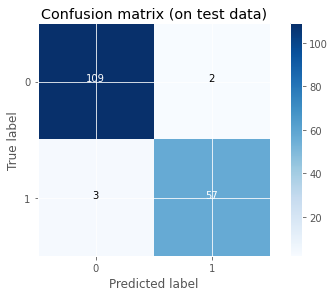

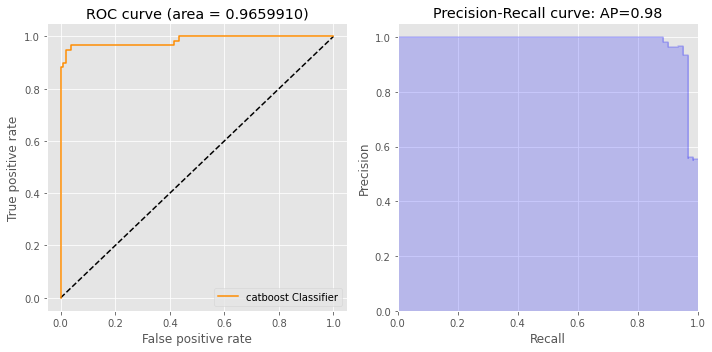

In [124]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from tabulate import tabulate
import numpy as np

folds = 5
param_comb = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 10345)
scoring_strings = ['accuracy', 'precision', 'recall', 'f1',
                       'average_precision', 'roc_auc']
trainPerformanceData = pd.DataFrame(columns = ['Algorithm','Scoring Name','CV mean', 'CV std']) 
testPerformanceData = pd.DataFrame(columns = ['Algorithm','Accuracy','AUC','Precision','Recall','F1'])
# timing starts from this point for "start_time" variable
#start_time = timer(None)
for clf_name, clf in nonlr_clf_dict.items():
    for scoring in scoring_strings:
        scores = cross_val_score(clf, X_train, y_train, scoring=scoring, cv=skf,verbose=1, n_jobs=2)
        print("---------------------------------------------------------------------") 
        print(clf_name)
        print("---------------------------------------------------------------------") 
        print("Cross Validation scores on training data")
        print ('Scoring Name: CV mean: %.5f CV std: %.5f',scoring,np.mean(np.abs(scores)),np.std(scores))
        print("") 
        # append rows to an empty DataFrame 
        trainPerformanceData = trainPerformanceData.append({'Algorithm' : clf_name, 'Scoring Name' : scoring, 'CV mean' : np.mean(np.abs(scores)),'CV std' : np.std(scores)},  
                ignore_index = True) 
        
    clf.fit(X_train, y_train)
    y_predicted_test  = clf.predict(X_test)
    y_probabilities_test = clf.predict_proba(X_test)
    y_probabilities_success = y_probabilities_test[:, 1]

    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(y_test, y_probabilities_success)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_probabilities_success)

    mse        = mean_squared_error(y_test, y_predicted_test)
    logloss    = log_loss(y_test, y_predicted_test)
    accuracy   = accuracy_score(y_test, y_predicted_test)
    precision  = precision_score(y_test, y_predicted_test, average='binary')
    recall     = recall_score(y_test, y_predicted_test, average='binary')
    F1         = f1_score(y_test, y_predicted_test)
    r2         = r2_score(y_test, y_predicted_test)
    auc        = roc_auc_score(y_test, y_predicted_test)
    cm         = confusion_matrix(y_test, y_predicted_test)
    #testPerformanceData = testPerformanceData.append({'Algorithm' : clf_name,'Accuracy' : accuracy,'Average_Precision':average_precision,'F1' : F1 ,'Precision' : precision,'Recall' : recall,'AUC' : auc},ignore_index = True)
    Print_Model_Metrics(clf_name)
    Plot_Confusion_Matrix(clf)
    Plot_ROC_Precision_Recall(clf_name)
    #auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print("")  
    #print("AUC scores on testing data")       
    #print(clf_name, 'auc score:', auc)
#timer(start_time)

In [125]:
trainPerformanceData

,Algorithm,Scoring Name,CV mean,CV std
0,Logistic Regression,accuracy,0.972373,0.012223
1,Logistic Regression,precision,0.980417,0.016008
2,Logistic Regression,recall,0.947527,0.043701
3,Logistic Regression,f1,0.962802,0.017327
4,Logistic Regression,average_precision,0.994018,0.005365
...,...,...,...,...
67,catboost Classifier,precision,0.932765,0.060772
68,catboost Classifier,recall,0.947312,0.033962
69,catboost Classifier,f1,0.939014,0.040269
70,catboost Classifier,average_precision,0.988751,0.009116


In [126]:
trainPerformanceData_pvt=pd.pivot_table(trainPerformanceData,index=["Algorithm"],values=["CV mean"],columns=["Scoring Name"],aggfunc=[np.min])
trainPerformanceData_pvt

amin                    ...                    
                               CV mean                    ...                    
Scoring Name                  accuracy average_precision  ...    recall   roc_auc
Algorithm                                                 ...                    
AdaBoost Classifier           0.942278          0.979545  ...  0.901290  0.985507
Decision Tree Classifier      0.927152          0.841562  ...  0.914194  0.922540
Extra Trees Classifier        0.959905          0.988363  ...  0.934409  0.989529
Gradient Boosting Classifier  0.954778          0.986441  ...  0.947312  0.991757
KNeighbors Classifier         0.949810          0.971150  ...  0.927742  0.978638
Logistic Regression           0.972373          0.994018  ...  0.947527  0.994295
Random Forest Classifier      0.952373          0.988158  ...  0.940860  0.991622
SVM Classifier                0.959873          0.988331  ...  0.947527  0.989764
XGB Classifier                0.954810          0.986303  ...  0.953978  0.989867
XGBoost Classifierr           0.954810          0.986303  ...  0.953978  0.989867
catboost Classifier           0.952342          0.988751  ...  0.947312  0.992008
naive_bayes                   0.932278          0.960554  ...  0.914194  0.975617

[12 rows x 6 columns]

In [127]:
testPerformanceData.sort_values(by=['Algorithm'])

,Algorithm,Accuracy,AUC,Precision,Recall,F1
10,AdaBoost Classifier,0.953216,0.944820,0.948276,0.916667,0.932203
8,Decision Tree Classifier,0.900585,0.885135,0.877193,0.833333,0.854701
3,Extra Trees Classifier,0.959064,0.953153,0.949153,0.933333,0.941176
2,Gradient Boosting Classifier,0.912281,0.901802,0.881356,0.866667,0.873950
5,KNeighbors Classifier,0.947368,0.932658,0.963636,0.883333,0.921739
0,Logistic Regression,0.959064,0.949324,0.964912,0.916667,0.940171
1,Random Forest Classifier,0.953216,0.944820,0.948276,0.916667,0.932203
6,SVM Classifier,0.953216,0.940991,0.964286,0.900000,0.931034
4,XGB Classifier,0.964912,0.961486,0.950000,0.950000,0.950000
9,XGBoost Classifierr,0.964912,0.961486,0.950000,0.950000,0.950000


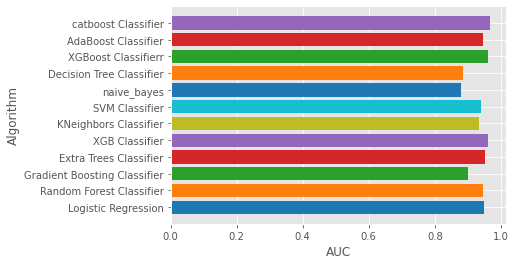

In [128]:
# plotting the coefficient score 
fig, ax = plt.subplots(figsize =(6, 4)) 
  
color =['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:cyan'] 
  
ax.barh(testPerformanceData["Algorithm"], testPerformanceData['AUC'], color = color) 
  
#ax.spines['bottom'].set_position('zero') 
plt.style.use('ggplot') 
plt.ylabel('Algorithm')
plt.xlabel('AUC')
#plt.title('AUC value of Algorithms ')
plt.show() 

## Conclusions

Thus, the most significant features in predicting malignant or benign for cancer patients obtained by algorithms are texture_mean, area_mean, concavity_mean, area_se, concavity_se, fractal_dimension_se, smoothness_worst, concavity_worst, symmetry_worst, fractal_dimension_worst.
To obtain best results from predictive model, many different models are trained, optimized, and evaluated using 16 set of features. During this process the feature set itself is culled using model-specific methods. Each model and subset of features is evaluated using Accuracy, AUC and sensitivity using a 5-fold cross-validation. Best results are obtained with Logistic regression, with the random forest feature set culled to 10 features. Above table shows the performance measures of the classification techniques. The logistic regression achieved an accuracy and AUC of 0.977 and 0.971 on test data.